# Natural Language Processing to detect offensive language in Social Media Posts



## Load all the required Libraries
Note that NLTK libs require downloads. Some of the libraries like Indic-Bert require loading as well. 

In [3]:
#All library imports are here
import numpy as np
import pandas as pd
import re
import string
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import keras
import tensorflow as tf
import tensorflow.python.keras.backend as K
from tensorflow.python.client import device_lib
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sklearn.metrics import make_scorer, f1_score, accuracy_score, recall_score, precision_score, classification_report, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.layers.core import Dense, Dropout, Activation, Lambda
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Set GPU or CPU
Set the Jupyter Notebook to execute in GPU or CPU based on availability
For the purpose of this project, I have used an NVIDIA GPU 3060 with 12GB GPU Memory and an Intel 12th Generation Desktop CPU with 16GB RAM

In [4]:
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')
device = 'cpu'

We are using device name "cuda"


## Dataset file from the paper
The dataset was found along with the paper in the implementation. This was downloaded from here:
https://github.com/SilentFlame/AggressionDetection 

In [5]:
#dataset_file = 'D:/project/ece570nlp/dataSet.csv'
dataset_file = './dataSet.csv'


## Read Dataset
First read the dataset file and use Pandas to convert the dataset CSV to a dataframe
The dataset consists of 3 columns and 12,000 records

In [6]:
# In this section we Read the dataset from the Paper
# Data is stored in csv format
# Load CSV using Pandas
filename = dataset_file
names = ['id', 'post', 'label']
df_original = pd.read_csv(filename, names=names, encoding='UTF-8')
# Display the shape of the dataframe
print(df_original.shape)

(12000, 3)


## Print the first 10 lines of the data as an example

In [7]:
first_10_rows = df_original.head(10)
print(first_10_rows)

                            id  \
0   facebook_corpus_msr_401470   
1   facebook_corpus_msr_386695   
2   facebook_corpus_msr_373389   
3   facebook_corpus_msr_917635   
4   facebook_corpus_msr_382517   
5   facebook_corpus_msr_403274   
6  facebook_corpus_msr_1723083   
7   facebook_corpus_msr_325257   
8    facebook_corpus_msr_23447   
9  facebook_corpus_msr_1477104   

                                                post label  
0  Mahmood Ghaznavi Aor ABdali ko bhol gaya ha tu...   OAG  
1  Bhai 60sal pehle desh me kya tha pehle pta kro...   CAG  
2  chutiya friday ko isliye releae krte kyoki wee...   CAG  
3                                         जय मोदीराज   CAG  
4     UPA walo ne bahot kuch kr diya tha desh k liye   CAG  
5  Pan ko Aadhar se link ki zarurat kuy hai? Supr...   CAG  
6  काकर पाथर जोड़ के मस्जिद लई बनाय।\n\nता चढ़ि मुल...   OAG  
7  Us raat tere papa k jageh mera sperm gya tha u...   OAG  
8                                       गटर के कीड़े   OAG  
9  Waise bandhu

## Change Hindi to English using a transliteration transformer
Clone the repository:

git clone https://github.com/libindic/indic-trans.git

------------------------OR--------------------------

git clone https://github.com/irshadbhat/indictrans.git

Change to the cloned directory:

<code>
cd indic-trans

pip install -r requirements.txt

python install .
</code>

Note that this has a Microsoft VC++ Executable version dependency and works only a specific machine where I had to use Windows 10 with the installable

In [ ]:
!\rm -rf /content/indic-trans
!git clone https://github.com/libindic/indic-trans.git
!cd /content/indic-trans
!pwd
!pip install -r /content/indic-trans/requirements.txt
!pip install /content/indic-trans/.
!cd /content
!pwd

    Cloning into 'indic-trans'...
    remote: Enumerating objects: 2214, done.
    remote: Counting objects: 100% (8/8), done.
    remote: Compressing objects: 100% (7/7), done.
    remote: Total 2214 (delta 2), reused 6 (delta 1), pack-reused 2206
    Receiving objects: 100% (2214/2214), 516.51 MiB | 21.67 MiB/s, done.
    Resolving deltas: 100% (1096/1096), done.
    Checking out files: 100% (719/719), done.
    /content
    Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
    Collecting pbr
      Downloading pbr-5.10.0-py2.py3-none-any.whl (112 kB)
         |████████████████████████████████| 112 kB 5.0 MB/s 
    Requirement already satisfied: six in /usr/local/lib/python3.7/dist-packages (from -r /content/indic-trans/requirements.txt (line 2)) (1.15.0)
    Requirement already satisfied: future in /usr/local/lib/python3.7/dist-packages (from -r /content/indic-trans/requirements.txt (line 3)) (0.16.0)
    Requirement already satisfied: cython>=0.24.0a0 in /usr/local/lib/python3.7/dist-packages (from -r /content/indic-trans/requirements.txt (line 4)) (0.29.32)
    Requirement already satisfied: numpy>=1.10.4 in /usr/local/lib/python3.7/dist-packages (from -r /content/indic-trans/requirements.txt (line 5)) (1.21.6)
    Requirement already satisfied: scipy>=0.13.3 in /usr/local/lib/python3.7/dist-packages (from -r /content/indic-trans/requirements.txt (line 6)) (1.7.3)
    Installing collected packages: pbr
    Successfully installed pbr-5.10.0
    Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
    Processing ./indic-trans
      DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
       pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
      Installing build dependencies ... done
      Getting requirements to build wheel ... done
      Installing backend dependencies ... done
        Preparing wheel metadata ... done
    Requirement already satisfied: numpy>=1.10.4 in /usr/local/lib/python3.7/dist-packages (from indictrans==1.2.3) (1.21.6)
    Requirement already satisfied: future in /usr/local/lib/python3.7/dist-packages (from indictrans==1.2.3) (0.16.0)
    Requirement already satisfied: scipy>=0.13.3 in /usr/local/lib/python3.7/dist-packages (from indictrans==1.2.3) (1.7.3)
    Requirement already satisfied: pbr in /usr/local/lib/python3.7/dist-packages (from indictrans==1.2.3) (5.10.0)
    Requirement already satisfied: six in /usr/local/lib/python3.7/dist-packages (from indictrans==1.2.3) (1.15.0)
    Requirement already satisfied: cython>=0.24.0a0 in /usr/local/lib/python3.7/dist-packages (from indictrans==1.2.3) (0.29.32)
    Building wheels for collected packages: indictrans
      Building wheel for indictrans (PEP 517) ... done
      Created wheel for indictrans: filename=indictrans-1.2.3-cp37-cp37m-linux_x86_64.whl size=337588249 sha256=33b58c1c99cd9cb5ec3d36908e3df8e100145d10560a2c2ed0f1dee1c620a185
      Stored in directory: /root/.cache/pip/wheels/49/d6/75/3af977ac266f07d63ee389fb1b4cec05f78cfede0ea5717f90
    Successfully built indictrans
    Installing collected packages: indictrans
    Successfully installed indictrans-1.2.3
    /content


## Transliterating the code
Now let us transliterate the code to change from Hindi to English for processing by the various different Models. The data is saved in file for later use on a machine with GPU

In [ ]:
from indictrans import Transliterator
trn = Transliterator(source='hin', target='eng', build_lookup=True)

processed_data_file = open('/content/drive/MyDrive/Colab Notebooks/ECE570-Fa22/Project/DataSetProcessed.csv', 'w')

for index, row in df_original.iterrows():
  try:
    hin = re.sub('\n+', ' ', row['post'])
    hin1 = re.sub(',', ' ', hin)
    eng = trn.transform(hin1)
    print(row['id'], "," , eng.encode('unicode-escape').decode(), ",",row['label'].replace(' ', ''), file=processed_data_file)
  except TypeError:
    continue

processed_data_file.close()

## Read the processed data back to a dataframe
The transliterated data which is saved in a csv file is read back into a dataframe for further processing

In [8]:
#dataset_processed_file = 'D:/project/ece570nlp/DataSetProcessed.csv'
dataset_processed_file = './DataSetProcessed.csv'

## Check the content
Check how the dataset now looks after the transliteration step

In [9]:
filename = dataset_processed_file
header = ['id', 'post', 'label']
df_processed = pd.read_csv(filename, names=header)
print(df_processed.shape)
print(df_processed.head(10))

(11999, 3)
                             id  \
0   facebook_corpus_msr_401470    
1   facebook_corpus_msr_386695    
2   facebook_corpus_msr_373389    
3   facebook_corpus_msr_917635    
4   facebook_corpus_msr_382517    
5   facebook_corpus_msr_403274    
6  facebook_corpus_msr_1723083    
7   facebook_corpus_msr_325257    
8    facebook_corpus_msr_23447    
9  facebook_corpus_msr_1477104    

                                                post label  
0   Mahmood Ghaznavi Aor ABdali ko bhol gaya ha t...   OAG  
1   Bhai 60sal pehle desh me kya tha pehle pta kr...   CAG  
2   chutiya friday ko isliye releae krte kyoki we...   CAG  
3                                       jai modiraj    CAG  
4    UPA walo ne bahot kuch kr diya tha desh k liye    CAG  
5   Pan ko Aadhar se link ki zarurat kuy hai? Sup...   CAG  
6   kaakar pathar jod ke masjid lai banaay. ta ch...   OAG  
7   Us raat tere papa k jageh mera sperm gya tha ...   OAG  
8                                    gater ke keede   

## Get some basic statistics
Now get some basic statisics from the dataset to know how long the texts are and how many words exist per category of lables

In [10]:
counts = df_original['label'].value_counts()
print(counts)

#Length of posts of each type

# for boolean indexing

CAG_posts_mean = df_processed.loc[df_original['label'].str.contains('CAG'), 'post'].replace(' ', '').apply(len).mean()
OAG_posts_mean = df_processed.loc[df_original['label'].str.contains('OAG'), 'post'].replace(' ', '').apply(len).mean()
NAG_posts_mean = df_processed.loc[df_original['label'].str.contains('NAG'), 'post'].replace(' ', '').apply(len).mean()


print("Mean of CAG", CAG_posts_mean)
print("Mean of OAG",OAG_posts_mean)
print("Mean of NAG",NAG_posts_mean)

CAG    4869
OAG    4856
NAG    2275
Name: label, dtype: int64
Mean of CAG 151.16577649958916
Mean of OAG 148.4112438220758
Mean of NAG 161.7098901098901


## Build a feature set from the posts
Now we build a feature set from the posts to check different properties

In [ ]:
badwords_file = './badWords.txt'

# coding: utf-8
file_no_id = './fileNoID.csv'

abuses = []
with open(badwords_file) as f:
    for word in f:
        word = word.strip('\n')
        abuses.append(word.lower())

f = open(file_no_id, 'r')
text = f.readlines()

count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

Emoticons = ["\U0001f602", "\U0001f620", "\U0001f1ee", "\U0001f1f3", "\U0001f3c2", "\U0001f31f", "\U0001f3fb", "\U0001f604","\U0001f64f", "\U0001f61c", "\U0001f60a", "\U0001f4af", "\U0001f518", "\U0001f44b", "\U0001f590"]

punct = []
upper = []
phone = []
urlBin = []
sentLen = []
avgWordLen = []
singleLetters = []
url = 0
hashTags = []

f1 = open('/content/drive/MyDrive/Colab Notebooks/ECE570-Fa22/Project/featureSet.csv', 'w+')

f1.write("text"+","+"AggWord"+","+"totalPunct"+","+"hashCount"+","+"totUpper"+","+"phoneNum"+","+"haveURL"+","+"totalTok"+","+"UniCount"+","+"avgWordSize"+","+"SentLen"+","+"tag"+"\n")
for line in text:
    line = line.strip('\n').split(',')
    tag = line[1]
    line = line[0]
    
    emoti = 0
    line = str(line)
    for em in Emoticons:
        if em in line.split(" "):
            print(em)
        
    
    agg=0
    for word in line.split(" "):
        if word.lower() in abuses:
            agg+=1
            
    punct_count = count(line, string.punctuation)
    upper_count = sum(1 for c in line if c.isupper())
    phone_count = line.count('+9')
    if('http:' in line):
        urlBin.append(1)
        url = 1
    else:
        urlBin.append(0)
        url = 0
    #print(punct_count)
    hash_count = sum(1 for c in line if c == '#')
    punct.append(punct_count)
    upper.append(upper_count)
    phone.append(phone_count)
    
    words = line.split(" ")
    sentLen.append(len(words))
    
    uniCount = sum(1 for x in words if len(x)==1)
    singleLetters.append(uniCount)
    
    tot = sum(len(x) for x in words)
    avgWordLen.append(int(tot/len(words)))
    str1 = (line+","+str(agg)+","+str(punct_count)+","+str(hash_count)+","+str(upper_count)+","+str(phone_count)+","+str(url)+","+str(len(words))+","+str(uniCount)+","+str(int(tot/len(words)))+","+str(len(line))+","+tag)
    f1.write(str1+"\n")

    
f1.close()

## Prepare the data for tokenization by removing features
This process is described in the paper with details on how we remove certain features like URLs, mentions, unicode, smileys etc

In [ ]:
# Prepare the data and remove or clean up for tokenization
# coding: utf-8
file_no_id = './fileNoID.csv'
data_cleanedup = './datacleanedup.csv'

file_handle1 = open(data_cleanedup, 'w')

f = open(file_no_id, 'r')
text = f.readlines()

count = 0
for line in text:
  line = line.strip('\n').split(',')
  tag = line[1]
  line = line[0]  
  line = re.sub(r'\+91\S+', '', line) # Remove phone numbers
  line = re.sub(r'https?://\S+', '', line) # Remove URLs
  line = re.sub(r"\\U\S+", '', line) # Remove unicode emojis
  line = line.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation  
  line = line.replace('\n', '')      
  line = re.sub('\t+', ' ', line)
  line.lower()
  file_handle1.write(line+','+tag+"\n")
  count = count+1

print(count)


## Drop the first column
We drop the first column of the dataset as we are not interesed in the IDs of the posts

In [11]:
df_processed = df_processed.iloc[: , 1:]  # Drop first column
print(df_processed.shape)

# Save without ID to csv file
file_no_id = 'D:/project/ece570nlp/fileNoID.csv'
df_processed.to_csv(file_no_id, index=False, header=False)

(11999, 2)


## Check point stage for faster loading and starting
This particular cell is used just to be able to load the project from this stage

In [12]:
file_no_id = './fileNoID.csv'
data_cleanedup = './datacleanedup.csv'

## Tokenization and train, test split
In this step we start tokenizing the dataset to convert them to tensors that can be further analyzed by the other models

In [13]:
header = ['post', 'label']
df_pretoken = pd.read_csv(data_cleanedup, header=None, names=header)
print(df_pretoken.shape)

X_pretoken = df_pretoken['post']
Y_pretoken = df_pretoken['label']

print(X_pretoken.shape)
print(Y_pretoken.shape)

tokenizer = Tokenizer(num_words=4000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,split=' ')
tokenizer.fit_on_texts(X_pretoken)
#print(tokenizer.word_index)

X = tokenizer.texts_to_sequences(X_pretoken)
#X = word_tokenize(str(X_pretoken))  # Using NLTK
#print(X)


sum_tot = 0
for seq in X:
    sum_tot += len(seq)

print(float(sum_tot/11634.0))

new_x = []
new_y = []

for i in range(0, len(X)):
    if len(X[i]) < 400:
        new_x.append(X[i])
        new_y.append(Y_pretoken[i])

print(len(new_x))
print(len(new_y))

X = pad_sequences(new_x)
Y = pd.get_dummies(new_y)

print(X.shape)
print(Y.shape)

#print(X)
#print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


X_train_tensor = torch.Tensor(X_train)
Y_train_tensor = torch.Tensor(np.array(Y_train))

X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)

X_test_tensor = torch.Tensor(X_test)
Y_test_tensor = torch.Tensor(np.array(Y_test))

X_test_tensor = X_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(11788, 2)
(11788,)
(11788,)
22.9778236204229
11773
11773
(11773, 387)
(11773, 3)
(9418, 387)
(9418, 3)
(2355, 387)
(2355, 3)
(9418, 387) (9418, 3)
(2355, 387) (2355, 3)


## MLP

### Build the MLP Network
We start the first model building by using MLP through Keras libraries

In [14]:

print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Deep Neural Network "MLP": multi layer Perceptron
#with tf.device('/GPU:0'):
model = Sequential()


model.add(Dense(256, input_dim=X_train.shape[1]))

# 0.42 accuracy.
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(3))
#model.add(Activation('softmax'))
model.add(Activation('sigmoid'))

# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18161546347864066205
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10081009664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3872883963768797412
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs Available:  1


### MLP Training

In [17]:
print("Training...")
model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

print("Generating test predictions...")
preds = model.predict(X_test, verbose=0)
print(preds)

# Evaluating the model
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 32)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

Training...
Epoch 1/10
236/236 [==============================] - 1s 4ms/step - loss: 1.3342 - accuracy: 0.4006 - val_loss: 1.0556 - val_accuracy: 0.4071
Epoch 2/10
236/236 [==============================] - 1s 3ms/step - loss: 1.2946 - accuracy: 0.4115 - val_loss: 1.0484 - val_accuracy: 0.4071
Epoch 3/10
236/236 [==============================] - 1s 3ms/step - loss: 1.1655 - accuracy: 0.4023 - val_loss: 1.0455 - val_accuracy: 0.4071
Epoch 4/10
236/236 [==============================] - 1s 2ms/step - loss: 1.0984 - accuracy: 0.3989 - val_loss: 1.0524 - val_accuracy: 0.4061
Epoch 5/10
236/236 [==============================] - 1s 2ms/step - loss: 1.1318 - accuracy: 0.4010 - val_loss: 1.0478 - val_accuracy: 0.4071
Epoch 6/10
236/236 [==============================] - 1s 2ms/step - loss: 1.1618 - accuracy: 0.4028 - val_loss: 1.0537 - val_accuracy: 0.4071
Epoch 7/10
236/236 [==============================] - 1s 2ms/step - loss: 1.1174 - accuracy: 0.4064 - val_loss: 1.0443 - val_accuracy: 0

### MLP Result Analysis
Calculate Recall, Precision and F1 scores for the MLP Model

In [18]:
predict = model.predict(X_test)
preds = predict
p = preds

tmpMat = np.zeros((len(Y_test), 3), dtype=int)
print(tmpMat.shape)
for i in range(0,len(predict)):
    if(p[i][0] > p[i][1] and p[i][0] > p[i][2]):
        tmpMat[i][0]=1
    elif(p[i][1] > p[i][0] and p[i][1] > p[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1

test_y = Y_test.to_numpy()


print("Overall")
print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))  



print("CAG")
print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))


print("NAG")
print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

print("OAG")
print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

74/74 [==============================] - 0s 1ms/step
(2355, 3)
Overall
0.1542771624722211
0.39278131634819535
0.22153824245248818
CAG
0.3428835968103281
0.5855626326963906
0.4325071614827652
NAG
0.6516020032365524
0.8072186836518047
0.7211102996344364
OAG
0.1542771624722211
0.39278131634819535
0.22153824245248818


c:\Users\nikhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nikhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nikhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nikhi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedM

## CNN

### Build the CNN Network

In [56]:
from keras.layers.convolutional import Convolution1D
from keras import backend as K

#CNN
# CNN: ConvNeuralNets

nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 2

print('Build model...')
model = Sequential()
model.add(Embedding(4000, 128))
model.add(Dropout(0.2))
# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
#model.add(Convolution1D(4000, 128, 
#                        activation='relu'))
model.add(Convolution1D(128,
                        3,
                        activation='relu'))


def max_1d(X_train):
    return K.max(X_train, axis=1)

model.add(Lambda(max_1d, output_shape=(nb_filter,)))
model.add(Dense(hidden_dims)) 
model.add(Dropout(0.2)) 
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Build model...


### CNN Training

In [59]:
print('Train...')
model.fit(X_train, Y_train, batch_size=100, epochs=25,
          validation_split=0.2)
score, acc = model.evaluate(X_test, Y_test, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/25
76/76 [==============================] - 1s 10ms/step - loss: 0.1708 - accuracy: 0.9097 - val_loss: 0.8041 - val_accuracy: 0.5425
Epoch 2/25
76/76 [==============================] - 1s 7ms/step - loss: 0.1146 - accuracy: 0.9445 - val_loss: 0.9144 - val_accuracy: 0.5467
Epoch 3/25
76/76 [==============================] - 1s 7ms/step - loss: 0.0806 - accuracy: 0.9643 - val_loss: 1.0622 - val_accuracy: 0.5393
Epoch 4/25
76/76 [==============================] - 1s 7ms/step - loss: 0.0594 - accuracy: 0.9753 - val_loss: 1.1473 - val_accuracy: 0.5366
Epoch 5/25
76/76 [==============================] - 1s 7ms/step - loss: 0.0518 - accuracy: 0.9793 - val_loss: 1.1695 - val_accuracy: 0.5494
Epoch 6/25
76/76 [==============================] - 1s 7ms/step - loss: 0.0471 - accuracy: 0.9792 - val_loss: 1.2187 - val_accuracy: 0.5430
Epoch 7/25
76/76 [==============================] - 1s 7ms/step - loss: 0.0378 - accuracy: 0.9849 - val_loss: 1.2773 - val_accuracy: 0.5425
Epoch 8/25

### CNN Result Analysis

In [60]:
predict = model.predict(X_test)
test_y = Y_test.to_numpy()
tmpMat = np.zeros((len(Y_test), 3), dtype=int)

for i in range(0,len(predict)):
    if(predict[i][0] > predict[i][1] and predict[i][0] > predict[i][2]):
        tmpMat[i][0]=1
    elif(predict[i][1] > predict[i][0] and predict[i][1] > predict[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1

print("Overall")
print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))  



print("CAG")
print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))


print("NAG")
print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

print("OAG")
print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

74/74 [==============================] - 0s 6ms/step
Overall
0.5596618849591647
0.5588110403397027
0.5585984732040872
CAG
0.6337002809184991
0.6288747346072187
0.6306040239017021
NAG
0.8106555125436221
0.8135881104033971
0.8120595507878147
OAG
0.6718791493799146
0.6751592356687898
0.6730916097936325


## LSTM

### Build the LSTM Network

In [19]:
# LSTM Model for prediction
embed_dim = 128
lstm_out = 196
batch_size = 100

model = Sequential()
#model.add(Embedding(4000, embed_dim,input_length = X.shape[1], dropout = 0.2))
model.add(Embedding(4000, embed_dim,input_length = X.shape[1]))
#model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
model.add(LSTM(lstm_out))
model.add(Dense(3,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 387, 128)          512000    
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense_3 (Dense)             (None, 3)                 591       
                                                                 
Total params: 767,391
Trainable params: 767,391
Non-trainable params: 0
_________________________________________________________________
None


### LSTM Training

In [20]:
model.fit(X_train, Y_train, batch_size = batch_size, epochs = 5, verbose = 2)

Epoch 1/5
95/95 - 6s - loss: 0.9768 - accuracy: 0.4835 - 6s/epoch - 62ms/step
Epoch 2/5
95/95 - 2s - loss: 0.7811 - accuracy: 0.6316 - 2s/epoch - 23ms/step
Epoch 3/5
95/95 - 2s - loss: 0.6506 - accuracy: 0.7117 - 2s/epoch - 22ms/step
Epoch 4/5
95/95 - 2s - loss: 0.5718 - accuracy: 0.7523 - 2s/epoch - 22ms/step
Epoch 5/5
95/95 - 2s - loss: 0.5085 - accuracy: 0.7883 - 2s/epoch - 22ms/step


### LSTM Result Analysis

In [21]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

24/24 - 1s - loss: 1.1152 - accuracy: 0.5533 - 615ms/epoch - 26ms/step
Score: 1.12
Validation Accuracy: 0.55


In [22]:
p = model.predict(X_test)

74/74 [==============================] - 1s 12ms/step


In [23]:
tmpMat = np.zeros((len(Y_test), 3), dtype=int)

for i in range(0,len(predict)):
    if(p[i][0] > p[i][1] and p[i][0] > p[i][2]):
        tmpMat[i][0]=1
    elif(p[i][1] > p[i][0] and p[i][1] > p[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1

test_y = Y_test.to_numpy()

print("Overall")
print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))  



print("CAG")
print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))


print("NAG")
print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

print("OAG")
print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

Overall
0.5520949794177357
0.5532908704883227
0.5511000884127953
CAG
0.616346625212543
0.6174097664543524
0.6168382980845307
NAG
0.8093195144827879
0.8208067940552017
0.8138038024016846
OAG
0.6758273053195597
0.6683651804670913
0.6708791145814581


## Naive Bayes

In [ ]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=X_train.shape[1], out_features=4000),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4000, out_features=3),
)

model = model.to(device)


ce_loss = nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

kl_weight = 0.1

for step in range(3000):
    pre = model(X_train_tensor)
    ce = ce_loss(pre, Y_train_tensor)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = Y_train_tensor.size(0)
correct = (predicted == Y_train_tensor).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))


In [23]:
correct = (predicted).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

- Accuracy: 39.966023 %
- CE : 6.88, KL : 0.54


In [68]:
model.eval()
predict = model(X_test_tensor)
preds = predict
p = preds

In [69]:
tmpMat = np.zeros((len(Y_test_tensor), 3), dtype=int)
#print(tmpMat.shape)
for i in range(0,len(predict)):
    if(p[i][0] > p[i][1] and p[i][0] > p[i][2]):
        tmpMat[i][0]=1
    elif(p[i][1] > p[i][0] and p[i][1] > p[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1


Y_test_tensor = Y_test_tensor.cpu().detach()
test_y = Y_test_tensor.numpy()



print("Overall")
print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))  



print("CAG")
print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))


print("NAG")
print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

print("OAG")
print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

Overall
0.36804285153385474
0.4
0.344361510786331
CAG
0.5403546512591435
0.4781316348195329
0.45233256669683325
NAG
0.7224094943619371
0.7677282377919321
0.7390552337650014
OAG
0.4932111101109997
0.554140127388535
0.4961576527172074


## SVM (Not Implemented)

In [26]:
#Import svm model
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer

# Decide on a percentage split 70/30
msk = np.random.rand(len(df_pretoken)) < 0.7
train_df = df_pretoken[msk]
test_df = df_pretoken[~msk]

print(train_df.shape)
print(test_df.shape)

#print(train_df.head(10))

vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, 
                            sublinear_tf=True, use_idf=True)
train_features = vectorizer.fit_transform(train_df['post'])
test_features = vectorizer.transform(test_df['post'])
print(train_features.shape)

#Create a svm Classifier
model = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
model.fit(train_features, train_df['label'])

#Predict the response for test dataset
predict = model.predict(test_features)

(8218, 2)
(3570, 2)
(8218, 4393)


In [27]:
preds = predict
p = preds

In [28]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_df['label'],predict))

Accuracy: 0.5826330532212886


## Transfer Learning

### Get the indic bert transformer

In [70]:
from transformers import AutoModel, AutoTokenizer, AlbertConfig

tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert', return_dict=False)
bert = AutoModel.from_pretrained('ai4bharat/indic-bert', return_dict=False)

print(bert)
#bert.embeddings.word_embeddings = nn.Embedding(4000,128,padding_idx=0)
#bert.pooler = nn.Linear(in_features = 768, out_features=3)

#xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')
#config = AlbertConfig()
bert.config.vocab_size = tokenizer.vocab_size  # setting both to have same vocab size

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'sop_classifier.classifier.bias', 'predictions.bias', 'predictions.decoder.bias', 'sop_classifier.classifier.weight', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(200000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False)
     

### Display a few lines of the dataset

In [71]:
df_pretoken.head

<bound method NDFrame.head of                                                     post label
0       Mahmood Ghaznavi Aor ABdali ko bhol gaya ha t...   OAG
1       Bhai 60sal pehle desh me kya tha pehle pta kr...   CAG
2       chutiya friday ko isliye releae krte kyoki we...   CAG
3                                           jai modiraj    CAG
4        UPA walo ne bahot kuch kr diya tha desh k liye    CAG
...                                                  ...   ...
11783       Pak congress ne hi di hui den hai duniya ko    CAG
11784   or shart yah hogi ki un fiter jet plance kaa ...   OAG
11785   abhi thodi der main grahamantri ji kadi ninda...   CAG
11786   mai bas main baitha tha  mere bagal main ek a...   OAG
11787   Aziz Hala thodi si chook kar di tuune  ajij h...   OAG

[11788 rows x 2 columns]>

### Split the training and testing datasets


In [72]:
# split train dataset into train, validation and test sets
df_pretoken['label'] = df_pretoken['label'].replace([" CAG"," OAG"," NAG"],[0,1,2]) 


print(df_pretoken.head)

<bound method NDFrame.head of                                                     post  label
0       Mahmood Ghaznavi Aor ABdali ko bhol gaya ha t...      1
1       Bhai 60sal pehle desh me kya tha pehle pta kr...      0
2       chutiya friday ko isliye releae krte kyoki we...      0
3                                           jai modiraj       0
4        UPA walo ne bahot kuch kr diya tha desh k liye       0
...                                                  ...    ...
11783       Pak congress ne hi di hui den hai duniya ko       0
11784   or shart yah hogi ki un fiter jet plance kaa ...      1
11785   abhi thodi der main grahamantri ji kadi ninda...      0
11786   mai bas main baitha tha  mere bagal main ek a...      1
11787   Aziz Hala thodi si chook kar di tuune  ajij h...      1

[11788 rows x 2 columns]>


### One Hot Encoder

In [73]:
# importing one hot encoder 
from sklearn.preprocessing import OneHotEncoder

# creating one hot encoder object 
onehotencoder = OneHotEncoder()
#reshape the 1-D label array to 2-D as fit_transform expects 2-D and finally fit the object 
X = onehotencoder.fit_transform(df_pretoken.label.values.reshape(-1,1)).toarray()
#X = onehotencoder.fit_transform(df_pretoken.label.values.reshape(-1,1))
print(X.shape)
#To add this back into the original dataframe
dfOneHot = pd.DataFrame(X, columns = ["label_"+str(int(i)) for i in range(df_pretoken.shape[1]+1)]) 
#dfOneHot = pd.DataFrame(X, columns= 'labels_onehot') 
print(dfOneHot)
#dfOneHot = pd.DataFrame(X) 
df_pretoken = pd.concat([df_pretoken, dfOneHot], axis=1)
#droping the country column 
df_pretoken= df_pretoken.drop(['label'], axis=1) 
df_pretoken['label'] = df_pretoken[['label_0', 'label_1', 'label_2']].values.tolist()
df_pretoken= df_pretoken.drop(['label_0'], axis=1) 
df_pretoken= df_pretoken.drop(['label_1'], axis=1) 
df_pretoken= df_pretoken.drop(['label_2'], axis=1) 
#printing to verify 
print(df_pretoken.head())

(11788, 3)
       label_0  label_1  label_2
0          0.0      1.0      0.0
1          1.0      0.0      0.0
2          1.0      0.0      0.0
3          1.0      0.0      0.0
4          1.0      0.0      0.0
...        ...      ...      ...
11783      1.0      0.0      0.0
11784      0.0      1.0      0.0
11785      1.0      0.0      0.0
11786      0.0      1.0      0.0
11787      0.0      1.0      0.0

[11788 rows x 3 columns]
                                                post            label
0   Mahmood Ghaznavi Aor ABdali ko bhol gaya ha t...  [0.0, 1.0, 0.0]
1   Bhai 60sal pehle desh me kya tha pehle pta kr...  [1.0, 0.0, 0.0]
2   chutiya friday ko isliye releae krte kyoki we...  [1.0, 0.0, 0.0]
3                                       jai modiraj   [1.0, 0.0, 0.0]
4    UPA walo ne bahot kuch kr diya tha desh k liye   [1.0, 0.0, 0.0]


### Train test split

In [74]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df_pretoken['post'], df_pretoken['label'], random_state=2018, test_size=0.3, stratify=df_pretoken['label'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size=0.5, stratify=temp_labels)

In [75]:
print(train_labels)
print(test_labels)

4461     [0.0, 1.0, 0.0]
6340     [0.0, 1.0, 0.0]
459      [0.0, 1.0, 0.0]
3800     [1.0, 0.0, 0.0]
10837    [1.0, 0.0, 0.0]
              ...       
1859     [0.0, 1.0, 0.0]
1932     [1.0, 0.0, 0.0]
3968     [0.0, 0.0, 1.0]
7449     [0.0, 1.0, 0.0]
9319     [0.0, 0.0, 1.0]
Name: label, Length: 8251, dtype: object
4318    [0.0, 0.0, 1.0]
2621    [0.0, 1.0, 0.0]
6485    [1.0, 0.0, 0.0]
4278    [1.0, 0.0, 0.0]
7374    [0.0, 1.0, 0.0]
             ...       
775     [1.0, 0.0, 0.0]
1620    [0.0, 1.0, 0.0]
8982    [1.0, 0.0, 0.0]
3936    [1.0, 0.0, 0.0]
5403    [1.0, 0.0, 0.0]
Name: label, Length: 1769, dtype: object


### Check the Bert Model

In [76]:
# sample data
text = ["chutiya friday ko isliye releae krte kyoki", "Pak congress ne hi di hui den hai duniya"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[2, 87921, 159856, 63199, 5124, 39649, 54, 2444, 75482, 1642, 4808, 578, 263, 8, 112893, 5133, 9472, 52948, 10567, 3], [2, 8, 105754, 77387, 68487, 44554, 13885, 41805, 782, 112721, 31279, 20616, 179444, 3, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]}


### Tokenize the sentences

<AxesSubplot:>

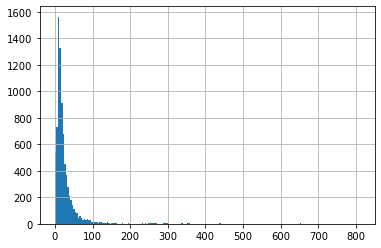

In [77]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 200)

In [78]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 150,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 150,
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 150,
    padding=True,
    truncation=True
)

### Convert list to tensors

In [79]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


### Create Training and validation Set

In [80]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 8

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Print train_dataloader
#print(train_dataloader)

### Define model architecture

In [81]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = True

#bert.embeddings.word_embeddings = nn.Embedding(4000,128,padding_idx=0)
#bert.pooler = nn.Linear(in_features = 768, out_features=3)
print(bert)

#model = bert


bert.config.vocab_size = 4000
print(bert.config.vocab_size)

# push the model to GPU
#model = model.to(device)

AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(200000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False)
     

### Bert model

In [82]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
     
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)
      
      #softmax activation function
      #self.softmax = nn.LogSoftmax(dim=1)
      self.softmax = nn.LogSoftmax()
      #self.sigmoid = nn.Sigmoid()
      #self.gelu = nn.GELU()
      #self.tanh = nn.Tanh()
      

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)

      x = self.fc1(cls_hs)
      
      x = self.relu(x)

      x = self.dropout(x)

      # output layer
 
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)
      #x = self.sigmoid(x)
      #x = self.gelu(x)
      #x = self.tanh(x)

      return x

In [83]:
class BERT_Arch1(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch1, self).__init__()

      self.bert = bert 
     
      # dense layer 1
      #self.fc1 = nn.Linear(768,512)

      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(768,3)
      
      #softmax activation function
      #self.softmax = nn.LogSoftmax(dim=1)
      #self.softmax = nn.LogSoftmax()
      #self.sigmoid = nn.Sigmoid()
      #self.gelu = nn.GELU()
      #self.tanh = nn.Tanh()
      

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)

      #x = self.fc1(cls_hs)
      
      # output layer
 
      x = self.fc2(cls_hs)
      
      # apply softmax activation
      #x = self.softmax(x)
      #x = self.sigmoid(x)
      #x = self.gelu(x)
      #x = self.tanh(x)

      return x

### Pass the model

In [84]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
#model = BERT_Arch1(bert)

# push the model to GPU
model = model.to(device)

### Optimizer

In [85]:
# optimizer from hugging face transformers
from torch.optim import AdamW
from torch.optim import Adam

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5)          # learning rate

### Class implementation

In [86]:
from sklearn.utils.class_weight import compute_class_weight

class_series = []
#print(train_labels)
for i in train_labels:
    value = np.argmax(i,axis=0)
    #print(value)
    class_series.append(value)

#print(class_series)


class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(class_series),
                                        y = class_series
                                    )

#class_weights = compute_class_weight(
#                                        class_weight = "balanced",
#                                        classes = np.unique(train_labels),
#                                        y = train_labels
#                                    )

print("Class Weights:",class_weights)

Class Weights: [0.82124017 0.82369971 1.75965025]


### Class weight to tensor

In [87]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)
print(weights)

# push to GPU
weights = weights.to(device)

# define the loss function
#cross_entropy  = nn.CrossEntropyLoss(weight=weights) 
#cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=torch.Tensor([0,1,2]), logits=torch.Tensor([0,1,2]))
#cross_entropy = [0.6931472 ,  0.31326172 , -1.873072]
#cross_entropy = nn.CrossEntropyLoss()
#cross_entropy = nn.NLLLoss(weight=weights) 
#cross_entropy = nn.MultiLabelSoftMarginLoss(weight=weights)
#cross_entropy = nn.BCEWithLogitsLoss()
#cross_entropy = nn.BCELoss()
#print(cross_entropy)

# number of training epochs
#epochs = 10

tensor([0.8212, 0.8237, 1.7597])


In [88]:
def cross_entropy(outputs, targets):
#    #return torch.nn.CrossEntropyLoss()(outputs, targets)
    #return torch.nn.MultiLabelSoftMarginLoss()
    return torch.nn.BCEWithLogitsLoss()(outputs,targets)

### Fine tune indic bert

In [89]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    #batch = [r for r in batch]
 
    sent_id, mask, labels = batch
   
    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
  
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

### Evaluation Function

In [90]:
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time

# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
         
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    #batch = [t for t in batch]
    
    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Start fine tuning bert model

In [91]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

epochs = 15

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 15


C:\Users\nikhi\AppData\Local\Temp\ipykernel_22068\3742502768.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


  Batch    50  of  1,032.
  Batch   100  of  1,032.
  Batch   150  of  1,032.
  Batch   200  of  1,032.
  Batch   250  of  1,032.
  Batch   300  of  1,032.
  Batch   350  of  1,032.
  Batch   400  of  1,032.
  Batch   450  of  1,032.
  Batch   500  of  1,032.
  Batch   550  of  1,032.
  Batch   600  of  1,032.
  Batch   650  of  1,032.
  Batch   700  of  1,032.
  Batch   750  of  1,032.
  Batch   800  of  1,032.
  Batch   850  of  1,032.
  Batch   900  of  1,032.
  Batch   950  of  1,032.
  Batch 1,000  of  1,032.

Evaluating...
  Batch    50  of    221.
  Batch   100  of    221.
  Batch   150  of    221.
  Batch   200  of    221.

Training Loss: 0.628
Validation Loss: 0.626

 Epoch 2 / 15
  Batch    50  of  1,032.
  Batch   100  of  1,032.
  Batch   150  of  1,032.
  Batch   200  of  1,032.
  Batch   250  of  1,032.
  Batch   300  of  1,032.
  Batch   350  of  1,032.
  Batch   400  of  1,032.
  Batch   450  of  1,032.
  Batch   500  of  1,032.
  Batch   550  of  1,032.
  Batch   600  

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
#!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()                          

### Make predictions

In [94]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### Check performance

In [95]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()


preds = np.argmax(preds, axis = 1)
print(preds)

y_test_arg=np.argmax(test_y,axis=1)
#y_test_arg = test_y
print(y_test_arg.shape)

print(classification_report(y_test_arg, preds))


[0 1 0 ... 1 0 0]
torch.Size([1769])
              precision    recall  f1-score   support

           0       0.51      0.72      0.60       718
           1       0.62      0.47      0.54       716
           2       0.77      0.44      0.56       335

    accuracy                           0.57      1769
   macro avg       0.63      0.54      0.56      1769
weighted avg       0.60      0.57      0.56      1769



C:\Users\nikhi\AppData\Local\Temp\ipykernel_22068\3742502768.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


In [96]:
# confusion matrix
pd.crosstab(y_test_arg, preds)

col_0,0,1,2
row_0,,,
0,520,173,25
1,358,340,18
2,151,38,146


In [97]:
model.eval()
predict = model(test_seq.to(device), test_mask.to(device))
tmpMat = np.zeros((len(test_y), 3), dtype=int)

for i in range(0,len(predict)):
    if(predict[i][0] > predict[i][1] and predict[i][0] > predict[i][2]):
        tmpMat[i][0]=1
    elif(predict[i][1] > predict[i][0] and predict[i][1] > predict[i][2]):
        tmpMat[i][1]=1
    else:
        tmpMat[i][2]=1
        
print(precision_score(test_y, tmpMat, average='weighted'))
print(recall_score(test_y, tmpMat, average='weighted'))
print(f1_score(test_y, tmpMat, average='weighted'))

print(precision_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(recall_score(test_y[:,0], tmpMat[:,0], average='weighted'))
print(f1_score(test_y[:,0], tmpMat[:,0], average='weighted'))

print(precision_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(recall_score(test_y[:,1], tmpMat[:,1], average='weighted'))
print(f1_score(test_y[:,1], tmpMat[:,1], average='weighted'))

print(precision_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(recall_score(test_y[:,2], tmpMat[:,2], average='weighted'))
print(f1_score(test_y[:,2], tmpMat[:,2], average='weighted'))

RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 815155200 bytes.